In [1]:
import numpy as np
import scipy
import os 
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm, expon, lognorm, rayleigh, weibull_min, chi, nakagami, rice, pareto, gamma, beta, invgauss
from scipy.signal import find_peaks
from scipy.stats._continuous_distns import FitError
from sklearn.covariance import EllipticEnvelope

def read_traffic_data(filename, time_window=0.05):
    captures = []
    with open(filename, 'r') as file:
        for line in file:
            parts = line.strip().split()
            url = parts[0]
            number_of_packets = int(parts[1])
            timestamps_bytes = parts[2:]
            
            timestamps = []
            incoming_packet_counts = []
            incoming_byte_counts = []

            timestamps_outgoing = []
            outgoing_byte_counts = []
            packet_count = 0
            
            for tb in timestamps_bytes:
                timestamp, nb_of_bytes = tb.split(':')
                timestamp = float(timestamp)
                nb_of_bytes = int(nb_of_bytes)
                if nb_of_bytes > 0:  # Consider only incoming packets
                    timestamps.append(timestamp)
                    incoming_packet_counts.append(1)
                    incoming_byte_counts.append(nb_of_bytes)
                else:
                    timestamps_outgoing.append(timestamp)
                    outgoing_byte_counts.append(nb_of_bytes)
            
            # Aggregate packet counts within time windows
            df = pd.DataFrame({'timestamp': timestamps, 'count': incoming_packet_counts, "bytes": incoming_byte_counts})
            df['time_window'] = (df['timestamp'] // (time_window * 1000)) * (time_window * 1000)
            aggregated_data = df.groupby('time_window').agg( 
                count=('count', 'sum'), 
                bytes_count=('bytes', 'sum'),
                bytes=('bytes', list), # Aggregates 'bytes' into a list,
                timestamp=('timestamp', list)
            ).reset_index()

            # Aggregate packet counts within time windows
            df_out = pd.DataFrame({'timestamp': timestamps_outgoing, "bytes": outgoing_byte_counts})
            df_out['time_window'] = (df_out['timestamp'] // (time_window * 1000)) * (time_window * 1000)
            aggregated_data_out = df_out.groupby('time_window').agg( 
                bytes=('bytes', list), # Aggregates 'bytes' into a list,
                timestamp=('timestamp', list)
            ).reset_index()
            
            captures.append((aggregated_data['time_window'].values, aggregated_data['count'].values, aggregated_data['bytes_count'].values, aggregated_data['bytes'].values, aggregated_data['timestamp'].values, aggregated_data_out['bytes'].values, aggregated_data_out['timestamp'].values))
    
    return captures

In [ ]:
# Read traffic data from files
directory = '../../data/reduced_list/configuration00_default/'

captures = []

for filename in os.listdir(directory):
    filepath = os.path.join(directory, filename)
    #print(filepath)
    if os.path.isfile(filepath):
        #print(f"Processing file: {filename}")
        captures.extend(read_traffic_data(filepath))
        


In [3]:
len(captures)

18257

In [5]:
import pickle
import os

# Create processed_data directory if it doesn't exist
os.makedirs('processed_data', exist_ok=True)

# Save the data to a pickle file
with open('processed_data/captures_default.pkl', 'wb') as f:
    pickle.dump(captures, f)

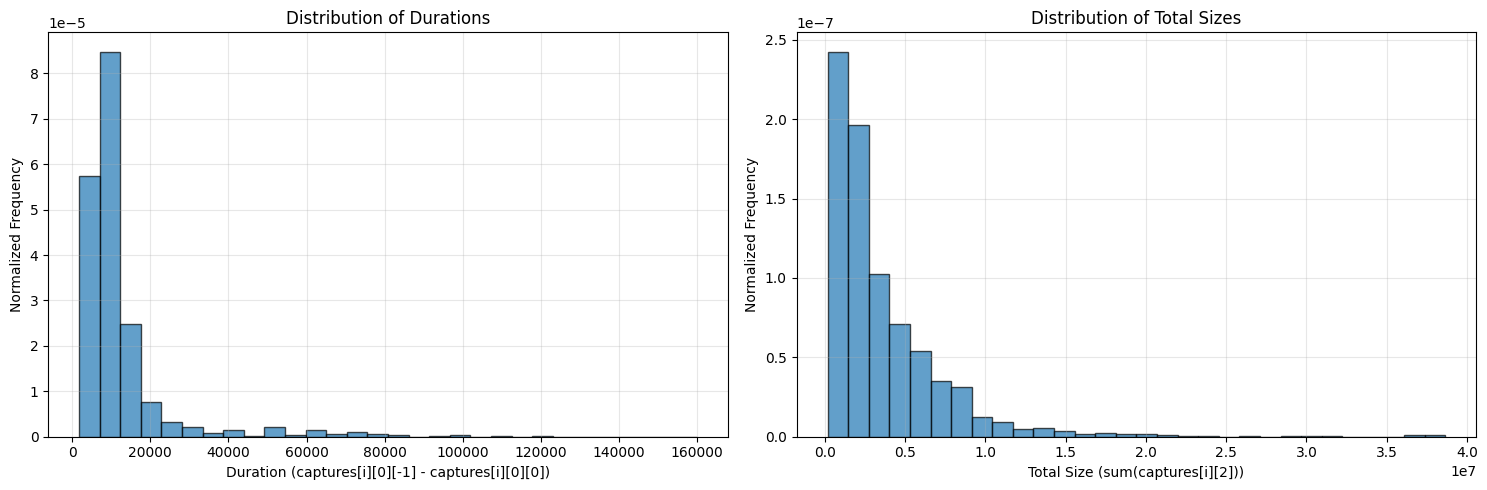

Duration stats: mean=12265.632, std=12873.476
Total size stats: mean=3613108.680, std=3847461.237


In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Extract the two values
durations = [captures[i][0][-1] - captures[i][0][0] for i in range(len(captures))]
total_sizes = [sum(captures[i][2]) for i in range(len(captures))]

# Create two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: Duration distribution (normalized)
ax1.hist(durations, bins=30, density=True, alpha=0.7, edgecolor='black')
ax1.set_xlabel('Duration (captures[i][0][-1] - captures[i][0][0])')
ax1.set_ylabel('Normalized Frequency')
ax1.set_title('Distribution of Durations')
#ax1.set_xscale('log')  # Add log scale to x-axis
ax1.grid(True, alpha=0.3)

# Plot 2: Total size distribution (normalized)
ax2.hist(total_sizes, bins=30, density=True, alpha=0.7, edgecolor='black')
ax2.set_xlabel('Total Size (sum(captures[i][2]))')
ax2.set_ylabel('Normalized Frequency')
ax2.set_title('Distribution of Total Sizes')
#ax2.set_xscale('log')  # Add log scale to x-axis
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print basic stats
print(f"Duration stats: mean={np.mean(durations):.3f}, std={np.std(durations):.3f}")
print(f"Total size stats: mean={np.mean(total_sizes):.3f}, std={np.std(total_sizes):.3f}")

In [7]:
import numpy as np
import scipy
import random
from scipy.stats import norm, expon, lognorm, rayleigh, weibull_min, chi, nakagami, rice, pareto, gamma, beta, invgauss, expon
from scipy.stats._continuous_distns import FitError
from scipy.signal import find_peaks
from collections import defaultdict

# List of distributions to consider
distributions = [norm, expon, lognorm, rayleigh, weibull_min, chi, nakagami, rice, pareto, gamma, beta, invgauss, expon]

# Function to fit distributions and find the best fit
def fit_distributions(data, distributions):
    dist_results = []
    
    for dist in distributions:
        try:
            params = dist.fit(data)
            # Goodness-of-fit tests
            D, p_value = scipy.stats.kstest(data, dist.cdf, args=params)
            dist_results.append((dist, p_value, params))
        except (FitError, ValueError) as e:
            print(f"Could not fit {dist.name}: {e}")
    
    return dist_results

# Function to discard outliers
def discard_outliers(data):
    from sklearn.covariance import EllipticEnvelope
    ee = EllipticEnvelope(contamination=0.1, support_fraction=0.7)
    data_reshaped = data.reshape(-1, 1)
    inliers = ee.fit_predict(data_reshaped) > 0
    return data[inliers]


# Analyze each capture separately and collect spike data
all_spike_heights = []
all_intervals_between_spikes = []
bytes_spike = []
max_spike = []
width_spike = []
mean_times = []
thresholds = []
ts_intra = []
ts_intra_list = []

for capture_id, (timestamps, packet_counts, bytes_count, bytes, ts, _, _) in enumerate(captures, start=1):
    counts = bytes_count
    # Detect peaks
    median_packets = int(np.median(packet_counts))
    median = np.median(counts)
    mad = np.median(np.abs(counts - median))
    threshold = median + 4 * mad
    thresholds.append(threshold)
    #peaks, _ = find_peaks(packet_counts, height=threshold)
    peaks = [index for index, value in enumerate(counts) if value >= threshold]

    last_peaks_end = 0
    peaks_starts_ends = []
    for peak in peaks:
        
        if peak <= last_peaks_end:
            continue
            
        start = peak
        for i in range(peak, -1, -1):
            if counts[i] <= median + mad:
                start = i + 1
                break
        
        # Find end of the peak
        for i in range(peak, len(counts)):
            if counts[i] <= median + mad:
                last_peaks_end = i
                break
           
        if last_peaks_end > start:
            peaks_starts_ends.append((start, last_peaks_end))     
            
            width_spike.append(timestamps[last_peaks_end] - timestamps[start])

            for i in range(start, last_peaks_end):
                all_spike_heights.append(max(counts[i] - (median + mad), 0))

            bytes_spike.append(bytes[start: last_peaks_end])
            ts_intra.append(sum(ts[start:last_peaks_end], []))
            ts_intra_list.append([random.sample(sublist, len(sublist) - median_packets) if len(sublist) > median_packets else [] for sublist in ts[start:last_peaks_end]])
            max_spike.append(max(np.max(counts[start: last_peaks_end]) - (median + mad), 0))

    peaks_starts = [start for start, end in peaks_starts_ends]
    # Compute intervals between spikes
    if len(peaks_starts) > 1:
        intervals_between_spikes = np.diff(timestamps[peaks_starts])
        all_intervals_between_spikes.extend(intervals_between_spikes - 100)# linked to the fact that 2 peaks should be seperated by at least 2 times the window
        mean_times.append(timestamps[-1] - timestamps[0])
    # Store the duration of the capture
    

# Convert lists to numpy arrays
all_spike_heights = np.array(all_spike_heights)
all_intervals_between_spikes = np.array(all_intervals_between_spikes)
mean_times = np.array(mean_times)
#all_bytes_spikes = np.array(bytes_spike)
all_width_spike = np.array(width_spike)

# Discard outliers
all_spike_heights_clean = discard_outliers(all_spike_heights)
intervals_clean = discard_outliers(all_intervals_between_spikes) 
mean_times_clean = discard_outliers(mean_times)
all_width_spike_clean = discard_outliers(all_width_spike)

all_spike_heights_clean = all_spike_heights_clean[all_spike_heights_clean>0]

## Inter-arrival analysis

In [8]:
def compute_interarrival_times(timestamps):
    interarrival_times = []
    for ts in timestamps:
        interarrival_times.extend([ts[i+1] - ts[i] for i in range(len(ts) - 1)])
    return interarrival_times

interarrival_times = compute_interarrival_times(ts_intra)




In [9]:
from collections import Counter

def interarrival_times_to_dict(interarrival_times):
    counter = Counter(interarrival_times)
    return dict(counter)


interarrival_dict = interarrival_times_to_dict(interarrival_times)

In [10]:
from collections import Counter

def count_packet_sizes(array_of_arrays):
    counter = Counter()
    for sublist in array_of_arrays:
        for subsublist in sublist:
            counter.update(subsublist)
    return counter

bytes_counter = count_packet_sizes(bytes_spike)


Total data points: 58044
Times range: -0.028549 to 1.408355 seconds
Occurrences range: 1.0 to 286417.0


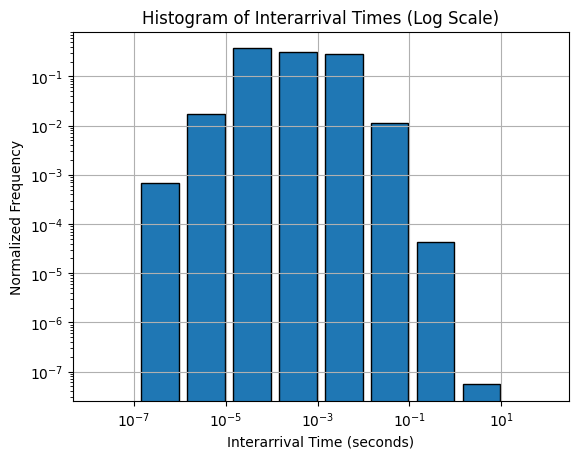

In [11]:
import matplotlib.pyplot as plt
import numpy as np

def plot_histogram(interarrival_dict):
    # Extract and flatten the data
    times_list = []
    occurrences_list = []
    
    for time_key, occurrence_value in interarrival_dict.items():
        if isinstance(occurrence_value, (list, tuple, np.ndarray)):
            # If value is a sequence, repeat the time for each occurrence
            for occ in occurrence_value:
                times_list.append(time_key)
                occurrences_list.append(occ)
        else:
            # Single value
            times_list.append(time_key)
            occurrences_list.append(occurrence_value)
    
    times = np.array(times_list) / 1000  # Convert ms to seconds
    occurrences = np.array(occurrences_list, dtype=float)
    
    print(f"Total data points: {len(times)}")
    print(f"Times range: {times.min():.6f} to {times.max():.6f} seconds")
    print(f"Occurrences range: {occurrences.min()} to {occurrences.max()}")

    # Set the bins to the specified values in seconds
    bins = [1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100]

    # Normalize occurrences by total sum
    normalized_occurrences = occurrences / occurrences.sum()

    plt.hist(times, bins=bins, weights=normalized_occurrences, edgecolor='black', rwidth=0.9)
    plt.yscale('log')
    plt.xscale('log')
    plt.title("Histogram of Interarrival Times (Log Scale)")
    plt.xlabel("Interarrival Time (seconds)")
    plt.ylabel("Normalized Frequency")
    plt.grid(True)
    plt.show()

# Run the fixed version
plot_histogram(interarrival_dict)

In [12]:
from collections import defaultdict

def process_timestamps(list_of_lists):
    packet_count = defaultdict(list)
    interarrival_times = defaultdict(list)
    
    for sublist in list_of_lists:
        # Calculate the height (maximum size) of any subsublist in the current sublist
        height = max(len(subsublist) for subsublist in sublist)
        
        # Calculate the total number of packets in all subsublists within the current sublist
        total_packets = sum(len(subsublist) for subsublist in sublist)
        
        # Update packet count for this height
        packet_count[height].append(total_packets)
        
        # Flatten and sort the sublist by timestamps 
        ts = sorted(sum(sublist, []))
        
        interarrival_times[height].extend([ts[i+1] - ts[i] for i in range(len(ts) - 1)])
    
    return packet_count, interarrival_times

packet_count, interarrival_times = process_timestamps(ts_intra_list)

In [13]:
height_counter = {height : len(list_nb_packets)for height, list_nb_packets in packet_count.items()}

In [14]:
def interarrival_times_to_dict(interarrival_times):
    counter = Counter(interarrival_times)
    return dict(counter)

nb_packets_counters = {height : interarrival_times_to_dict(list_nb_packets) for height, list_nb_packets in packet_count.items()}
interarrival_times_counters = {height : interarrival_times_to_dict(list_interarrival) for height, list_interarrival in interarrival_times.items()}

In [15]:
wtf_advanced = height_counter, nb_packets_counters, interarrival_times_counters

# peak distribution

In [ ]:
distributions = [gamma]
# Fit distributions to spike heights
spike_heights_fit_results = fit_distributions(all_spike_heights_clean, distributions)


distributions = [pareto, expon, lognorm, gamma, rayleigh]
# Fit distributions to intervals between spikes
intervals_fit_results = fit_distributions(intervals_clean, distributions)

distributions = [expon, lognorm, chi, gamma, rayleigh]

width_spike_fit_results = fit_distributions(all_width_spike_clean, distributions)

distributions = [gamma]
# Fit distributions to mean times
mean_times_fit_results = fit_distributions(mean_times_clean, distributions)

# Example function to find the best distribution by average p-value
def find_best_distribution(fit_results):
    best_dist = max(fit_results, key=lambda item: item[1])
    return best_dist

# Find best distributions and their parameters
best_spike_heights_dist = find_best_distribution(spike_heights_fit_results)
best_intervals_dist = find_best_distribution(intervals_fit_results)
best_width_dist = find_best_distribution(width_spike_fit_results)
best_mean_times_dist = find_best_distribution(mean_times_fit_results)

# Display the best fit results
print(f"Best distribution for spike heights: {best_spike_heights_dist[0].name} with parameters {best_spike_heights_dist[2]} and p-value {best_spike_heights_dist[1]}")
print(f"Best distribution for intervals between spikes: {best_intervals_dist[0].name} with parameters {best_intervals_dist[2]} and p-value {best_intervals_dist[1]}")
print(f"Best distribution for width times: {best_width_dist[0].name} with parameters {best_width_dist[2]} and p-value {best_width_dist[1]}")
print(f"Best distribution for mean times: {best_mean_times_dist[0].name} with parameters {best_mean_times_dist[2]} and p-value {best_mean_times_dist[1]}")


# NYM WTFPAD Advanced

In [17]:
def crop_capture_data(pairs):
    # crop captures when we added a 10 seconds of nothugn in the capture
    total_time = pairs[-1][0]
    final_time = int(total_time) - 10000
    cropped_pairs = [(timestamp, value) for timestamp, value in pairs if timestamp <= final_time]

    return cropped_pairs


In [18]:
import numpy as np
import pandas as pd
import os
import random

def draw_element_from_distribution(interarrival_dict):
    # Define the function properly based on your needs
    return np.random.choice(list(interarrival_dict.values()))

def generate_packets(size, probabilities):
    # Define the function properly based on your needs
    pass

def get_wtf_pairs(timestamps, data, interval_fit, height_generator, nb_packets_generators, interarrival_times_generators, bytes_generator, threshold):
    pairs_wtf = []
    
    all_spike_heights_clean = data  # Assuming this is the cleaned data
    interval_dist, interval_pval, interval_params = interval_fit
    
    # Initialize start_spike
    index = 0
    actual_timestamp = timestamps[index] + int(interval_dist.rvs(*interval_params)) + 100
    height = 0
    while height < 2:
        height = height_generator.get()
    width = nb_packets_generators[height].get()
    
    while actual_timestamp < timestamps[-1]:
        if index < len(timestamps) - 1 and actual_timestamp > timestamps[index+1]:
            while index < len(timestamps) - 1 and actual_timestamp > timestamps[index + 1]:
                if data[index] >= threshold:
                    actual_timestamp += 50
                    width = -1
                index += 1
                              
        if width <= 0:
            time_between_two_peaks = int(interval_dist.rvs(*interval_params)) + 100 # TODO change the factor 2
            #time_between_two_peaks = int(interval_dist.rvs(*interval_params)) + 100
            actual_timestamp += time_between_two_peaks
            height = 0
            while height < 2:
                height = height_generator.get()
            width = nb_packets_generators[height].get()
        else:
            packet_size = bytes_generator.get()
            pairs_wtf.append((actual_timestamp, packet_size))
            interarrival_time = interarrival_times_generators[height].get()
            actual_timestamp += interarrival_time
            width -= 1

    return pairs_wtf    

def apply_generate_packets_to_incoming(incoming_packet_sizes, probabilities):
    return [generate_packets(size, probabilities) for size in incoming_packet_sizes]

def merge_and_sort_by_timestamp(arrays_of_pairs):
    merged_pairs = [pair for array in arrays_of_pairs for pair in array]
    sorted_pairs = sorted(merged_pairs, key=lambda pair: pair[0])
    return sorted_pairs

def create_line(url, pairs):
    line_content = f"{url} {len(pairs)}"
    for timestamp, direction in pairs:
        line_content += f" {timestamp}:{direction}"
    line_content += "\n"
    return line_content

def create_syntetic_data(filename, input_dir, output_dir, interval_fit, height_generator, nb_packets_generators, interarrival_times_generators, bytes_generator, threshold, time_window=50, draw = False):
    filepath = os.path.join(input_dir, filename)
    output_content = ""
    
    with open(filepath, 'r') as file:
        for line in file:
            parts = line.strip().split()
            url = parts[0]
            timestamps_bytes = parts[2:]
            
            timestamps = []
            incoming_byte_counts = []

            outgoing_timestamps = []
            outgoing_byte_counts = []
            
            pairs = []

            start_time = float(timestamps_bytes[0].split(':')[0]) if draw else 0
            
            for tb in timestamps_bytes:
                if len(tb.split(':')) != 2:
                    print(url)
                else:
                    timestamp, nb_of_bytes = tb.split(':')
                    timestamp = float(timestamp) - start_time
                    nb_of_bytes = int(nb_of_bytes)
                    pairs.append((timestamp, nb_of_bytes))
                    
                    if nb_of_bytes > 0:  # Consider only incoming packets
                        timestamps.append(timestamp)
                        incoming_byte_counts.append(nb_of_bytes)
                    else:
                        outgoing_timestamps.append(timestamp)
                        outgoing_byte_counts.append(nb_of_bytes * -1)
                
            # Aggregate packet counts within time windows
            df = pd.DataFrame({'timestamp': timestamps, "bytes": incoming_byte_counts})
            df['time_window'] = (df['timestamp'] // time_window) * time_window
            aggregated_data = df.groupby('time_window').agg(
                bytes_count=('bytes', 'sum'),
            ).reset_index()
            
            real_capture_timestamps = aggregated_data['time_window'].values
            real_capture_bytes_count = aggregated_data['bytes_count'].values
            start_time = real_capture_timestamps[0]
            
            wtf_pairs = get_wtf_pairs(real_capture_timestamps, real_capture_bytes_count, interval_fit, height_generator, nb_packets_generators, interarrival_times_generators, bytes_generator, threshold)
            new_pairs = merge_and_sort_by_timestamp([pairs, wtf_pairs])
            #new_pairs = crop_capture_data(merge_and_sort_by_timestamp([pairs, wtf_pairs]))
            output_content += create_line(url, new_pairs)

            if draw:

                # Aggregate packet counts within time windows
                df = pd.DataFrame({'timestamp': [a for a,b in wtf_pairs], "bytes": [b for a,b in wtf_pairs]})
                df['time_window'] = (df['timestamp'] // time_window) * time_window
                df['bytes'] = df['bytes'].apply(lambda x: x if x != 0 else 0)
                                                
                data_wtf = df.groupby('time_window').agg( 
                    bytes_count=('bytes', 'sum'),
                ).reset_index()

                # Ensure that all time windows in df are represented in data_wtf, even if they have zero bytes
                all_time_windows = pd.DataFrame({'time_window': range(int(df['time_window'].min()), int(df['time_window'].max()) + time_window, time_window)})
                data_wtf = all_time_windows.merge(data_wtf, on='time_window', how='left').fillna(0)
                
                # Convert bytes_count back to integer after filling NaN values
                data_wtf['bytes_count'] = data_wtf['bytes_count'].astype(int)

                # Plot the synthetic data and real capture data together
                plt.figure(figsize=(8, 6))
                plt.plot(real_capture_timestamps, real_capture_bytes_count, label='Incoming traffic')
                plt.plot(data_wtf['time_window'].values, data_wtf['bytes_count'].values, label='Added Fake Bursts')
                #plt.title('Synthetic Data Superposed with Real Capture Data')
                plt.xlabel('Timestamp')
                plt.ylabel('Number of Bytes')
                plt.legend()
                plt.savefig('figures/WTF_separated.svg')
                plt.show()

                # Aggregate packet counts within time windows
                df = pd.DataFrame({'timestamp': [a for a,b in new_pairs if b > 0], "bytes": [b for a,b in new_pairs if b > 0]})
                df['time_window'] = (df['timestamp'] // time_window) * time_window
                data_new_pairs = df.groupby('time_window').agg( 
                    bytes_count=('bytes', 'sum'),
                ).reset_index()
                # Plot the synthetic data and real capture data together
                plt.figure(figsize=(8, 6))
                plt.plot(data_new_pairs['time_window'].values, data_new_pairs['bytes_count'].values, label='Incoming traffic')
                #plt.title('Synthetic Data Superposed with Real Capture Data')
                plt.xlabel('Timestamp')
                plt.ylabel('Number of Bytes')
                plt.legend()
                plt.savefig('figures/WTF_combined.svg')
                plt.show()

                
                
    with open(os.path.join(output_dir, filename), "w") as file:
        file.write(output_content)


In [19]:
import numpy as np
import pandas as pd
import os
import random

def aggregate_kilobytes(pairs, time_window):
    df = pd.DataFrame({'timestamp': [a for a, b in pairs], 'bytes': [b for a, b in pairs]})
    df['time_window'] = (df['timestamp'] // time_window) * time_window
    df['bytes'] = df['bytes'].apply(lambda x: x if x != 0 else 0)
    data = df.groupby('time_window').agg(bytes_count=('bytes', 'sum')).reset_index()

    all_windows = pd.DataFrame({'time_window': range(int(df['time_window'].min()),
                                                     int(df['time_window'].max()) + time_window,
                                                     time_window)})
    data = all_windows.merge(data, on='time_window', how='left').fillna(0)
    data['bytes_count'] = data['bytes_count'].astype(int)
    data['time_window'] = data['time_window'] / 1000  # Convert to seconds
    data['kilobytes'] = data['bytes_count'] / 1024  # Convert to KB
    return data

def plot_kilobytes(data_x, data_y, label, filename):
    plt.figure(figsize=(12, 7), dpi=300)
    plt.plot(data_x, data_y, label=label, linewidth=3, alpha=1)

    plt.xlabel("Timestamp (seconds)", fontsize=22)
    plt.ylabel("Number of kB", fontsize=22)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.grid(True, linestyle='--', alpha=0.4)
    plt.legend(fontsize=22)
    plt.tight_layout()

    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    plt.savefig(filename, format="pdf", dpi=300)
    plt.show()
        
def draw_element_from_distribution(interarrival_dict):
    # Define the function properly based on your needs
    return np.random.choice(list(interarrival_dict.values()))

def generate_packets(size, probabilities):
    # Define the function properly based on your needs
    pass

def get_wtf_pairs(timestamps, data, interval_fit, height_generator, nb_packets_generators, interarrival_times_generators, bytes_generator, threshold):
    pairs_wtf = []
    
    all_spike_heights_clean = data  # Assuming this is the cleaned data
    interval_dist, interval_pval, interval_params = interval_fit
    
    # Initialize start_spike
    index = 0
    actual_timestamp = timestamps[index] + int(interval_dist.rvs(*interval_params)) + 100
    height = 0
    while height < 2:
        height = height_generator.get()
    width = nb_packets_generators[height].get()
    
    while actual_timestamp < timestamps[-1]:
        if index < len(timestamps) - 1 and actual_timestamp > timestamps[index+1]:
            while index < len(timestamps) - 1 and actual_timestamp > timestamps[index + 1]:
                if data[index] >= threshold:
                    actual_timestamp += 50
                    width = -1
                index += 1
                              
        if width <= 0:
            time_between_two_peaks = int(interval_dist.rvs(*interval_params)) + 100 # TODO change the factor 2
            #time_between_two_peaks = int(interval_dist.rvs(*interval_params)) + 100
            actual_timestamp += time_between_two_peaks
            height = 0
            while height < 2:
                height = height_generator.get()
            width = nb_packets_generators[height].get()
        else:
            packet_size = bytes_generator.get()
            pairs_wtf.append((actual_timestamp, packet_size))
            interarrival_time = interarrival_times_generators[height].get()
            actual_timestamp += interarrival_time
            width -= 1

    return pairs_wtf    

def apply_generate_packets_to_incoming(incoming_packet_sizes, probabilities):
    return [generate_packets(size, probabilities) for size in incoming_packet_sizes]

def merge_and_sort_by_timestamp(arrays_of_pairs):
    merged_pairs = [pair for array in arrays_of_pairs for pair in array]
    sorted_pairs = sorted(merged_pairs, key=lambda pair: pair[0])
    return sorted_pairs

def create_line(url, pairs):
    line_content = f"{url} {len(pairs)}"
    for timestamp, direction in pairs:
        line_content += f" {timestamp}:{direction}"
    line_content += "\n"
    return line_content

def create_syntetic_data(filename, input_dir, output_dir, interval_fit, height_generator, nb_packets_generators, interarrival_times_generators, bytes_generator, threshold, time_window=50, draw = False):
    filepath = os.path.join(input_dir, filename)
    output_content = ""
    
    with open(filepath, 'r') as file:
        for line in file:
            parts = line.strip().split()
            url = parts[0]
            timestamps_bytes = parts[2:]
            
            timestamps = []
            incoming_byte_counts = []

            outgoing_timestamps = []
            outgoing_byte_counts = []
            
            pairs = []

            start_time = float(timestamps_bytes[0].split(':')[0]) if draw else 0
            
            for tb in timestamps_bytes:
                if len(tb.split(':')) != 2:
                    print(url)
                else:
                    timestamp, nb_of_bytes = tb.split(':')
                    timestamp = float(timestamp) - start_time
                    nb_of_bytes = int(nb_of_bytes)
                    pairs.append((timestamp, nb_of_bytes))
                    
                    if nb_of_bytes > 0:  # Consider only incoming packets
                        timestamps.append(timestamp)
                        incoming_byte_counts.append(nb_of_bytes)
                    else:
                        outgoing_timestamps.append(timestamp)
                        outgoing_byte_counts.append(nb_of_bytes * -1)
                
            # Aggregate packet counts within time windows
            df = pd.DataFrame({'timestamp': timestamps, "bytes": incoming_byte_counts})
            df['time_window'] = (df['timestamp'] // time_window) * time_window
            aggregated_data = df.groupby('time_window').agg(
                bytes_count=('bytes', 'sum'),
            ).reset_index()
            
            real_capture_timestamps = aggregated_data['time_window'].values
            real_capture_bytes_count = aggregated_data['bytes_count'].values
            start_time = real_capture_timestamps[0]
            
            wtf_pairs = get_wtf_pairs(real_capture_timestamps, real_capture_bytes_count, interval_fit, height_generator, nb_packets_generators, interarrival_times_generators, bytes_generator, threshold)
            new_pairs = merge_and_sort_by_timestamp([pairs, wtf_pairs])
            #new_pairs = crop_capture_data(merge_and_sort_by_timestamp([pairs, wtf_pairs]))
            output_content += create_line(url, new_pairs)

            if draw:

                data_wtf = aggregate_kilobytes(wtf_pairs, time_window)
                plt.figure(figsize=(12, 7), dpi=300)
                plt.plot(np.array(real_capture_timestamps) / 1000, np.array(real_capture_bytes_count) / 1024,
                         label='Incoming traffic', linewidth=3, alpha=1)
                plt.plot(data_wtf['time_window'].values, data_wtf['kilobytes'].values,
                         label='Added Fake Bursts', linewidth=3, alpha=1)
            
                plt.xlabel("Timestamp (seconds)", fontsize=22)
                plt.ylabel("Number of kB", fontsize=22)
                plt.xticks(fontsize=22)
                plt.yticks(fontsize=22)
                plt.grid(True, linestyle='--', alpha=0.4)
                plt.legend(fontsize=22)
                plt.tight_layout()
            
                ax = plt.gca()
                ax.spines['top'].set_visible(False)
                ax.spines['right'].set_visible(False)
            
                plt.savefig(os.path.join(output_dir, "WTF_separated.pdf"), format="pdf", dpi=300)
                plt.show()
            
                # Plot only new pairs with bytes > 0
                filtered_new_pairs = [(a, b) for a, b in new_pairs if b > 0]
                data_new_pairs = aggregate_kilobytes(filtered_new_pairs, time_window)
                plot_kilobytes(data_new_pairs['time_window'].values, data_new_pairs['kilobytes'].values,
                               label='Incoming traffic (seconds, KB)', filename=os.path.join(output_dir, "WTF_combined.pdf"))

                
                
    with open(os.path.join(output_dir, filename), "w") as file:
        file.write(output_content)


In [20]:
import random

class InterarrivalTimeGenerator:
    def __init__(self, interarrival_dict, size=1000000):
        self.interarrival_dict = interarrival_dict
        self.size = size
        self._generate_new_array()
        self.index = 0

    def _generate_new_array(self):
        elements = list(self.interarrival_dict.keys())
        weights = list(self.interarrival_dict.values())
        self.array = random.choices(elements, weights=weights, k=self.size)
        random.shuffle(self.array)

    def get(self):
        if self.index >= self.size:
            self.index = 0
            random.shuffle(self.array)
        value = self.array[self.index]
        self.index += 1
        return value

In [21]:
height_generator = InterarrivalTimeGenerator(height_counter)
nb_packets_generators = {height : InterarrivalTimeGenerator(list_nb_packets, size=100000) for height, list_nb_packets in nb_packets_counters.items()}
interarrival_times_generators = {height : InterarrivalTimeGenerator(list_interarrival, size=100000) for height, list_interarrival in interarrival_times_counters.items() if height != 0 and height!=1}
bytes_generator = InterarrivalTimeGenerator(bytes_counter, size=10000000)

In [22]:
interarrival_times_generators[1] = InterarrivalTimeGenerator({0: 1})

In [24]:
import pickle

# Save the data to a pickle file
with open('processed_data/wtf4nym_parameters.pkl', 'wb') as f:
    pickle.dump((best_intervals_dist, height_generator, nb_packets_generators, interarrival_times_generators, bytes_generator, threshold), f)

In [ ]:
pickle_file_path = "processed_data/wtf4nym_parameters.pkl"
with open(pickle_file_path, 'rb') as f:
    best_intervals_dist, height_generator, nb_packets_generators, interarrival_times_generators, bytes_generator, threshold = pickle.load(f)

threshold = threshold

# Use configuration00_default (the same as used for training earlier)
input_dir = '../../data/reduced_list/configuration00_default/'
output_dir = 'processed_data/nym_configuration00_default_wtf/'
os.makedirs(output_dir, exist_ok=True)

for filename in os.listdir(input_dir):
    
    filepath = os.path.join(input_dir, filename)
    
    if os.path.isfile(filepath):
        
        print(f"Processing file: {filename}")
        create_syntetic_data(filename, input_dir, output_dir, best_intervals_dist, height_generator, nb_packets_generators, interarrival_times_generators, bytes_generator, threshold, time_window=50)

FileNotFoundError: [Errno 2] No such file or directory: '../../data/reduced_list/nym_configuration00_default/'